<h1>DATASET LOADING</h1>

In [277]:
#imports
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

import random
import cv2
import matplotlib.pyplot as plt

import math
import itertools

In [278]:
# get dataset from drive
!gdown https://drive.google.com/uc?id=1Fjmt_xFGWKIHl8J7z8eIGhopobm7VzF1

# unzip dataset
!unzip -q /content/images_folder.zip

directory = 'images_folder/'
images= []

folder = os.path.join(directory)
for file in os.listdir(folder):
  images.append(directory + file)

images = np.sort(images)
img = []
for x in images[0:100]:
  img.append(Image.open(x))

# download annotation text file from drive
!gdown https://drive.google.com/uc?id=1FS21e-deAla84h6AWPBcMU0BPV-6sNIf

# store annotations in an array
file = '/content/annotations.txt'

with open(file) as f:
  lines = f.readlines()

# take labels and assign numerical values 
labels = ('background', 'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle',
          'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 
          'pottedplant', 'sofa', 'tvmonitor')

labels_map = {k:v for v,k in enumerate(labels)}
print(labels_map)

Downloading...
From: https://drive.google.com/uc?id=1Fjmt_xFGWKIHl8J7z8eIGhopobm7VzF1
To: /content/images_folder.zip
100% 1.34G/1.34G [00:06<00:00, 199MB/s]
replace images_folder/2008_000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Downloading...
From: https://drive.google.com/uc?id=1FS21e-deAla84h6AWPBcMU0BPV-6sNIf
To: /content/annotations.txt
100% 4.13M/4.13M [00:00<00:00, 132MB/s]
{'background': 0, 'person': 1, 'bird': 2, 'cat': 3, 'cow': 4, 'dog': 5, 'horse': 6, 'sheep': 7, 'aeroplane': 8, 'bicycle': 9, 'boat': 10, 'bus': 11, 'car': 12, 'motorbike': 13, 'train': 14, 'bottle': 15, 'chair': 16, 'diningtable': 17, 'pottedplant': 18, 'sofa': 19, 'tvmonitor': 20}


In [305]:
transform = transforms.ToTensor()

# parse annotations for image index
def parseAnnotations(idx):
  id = []
  labels = []
  bboxes = []
  numObj = []
  line = lines[idx]
  split = line.strip().split()
  id.append(split[0])

  numOfObj = int(split[1])
  numObj.append(numOfObj)
  for i in range(numOfObj):
    xmin = split[2+5*i]
    ymin = split[3+5*i]
    xmax = split[4+5*i]
    ymax = split[5+5*i]
    bboxes.append([float(xmin), float(ymin), float(xmax), float(ymax)])
    labels.append(labels_map[split[6+5*i]])

  tensorLabels = torch.LongTensor(labels)
  image = img[idx]
  resized_image = img[idx].resize((300,300))
  width, height = resized_image.size
  resized_image = transform(resized_image)
  tensorBoxes = torch.Tensor(bboxes)
  tensorBoxes /= torch.Tensor([width, height, width, height]).expand_as(tensorBoxes)
  return resized_image, id, tensorLabels, tensorBoxes, numObj #{'id': id, 'label': labels, 'bboxes': torch.Tensor(bboxes), 'numObj': numObj}

# get resized image, bboxes
# def getImage(idx):
#   image = img[idx]
#   id, labels, bboxes, numObj = parseAnnotations(idx)
#   # Scale the bounding boxes with 300x300 image
#   width, height = image.size
#   bboxes /= torch.Tensor([width, height, width, height]).expand_as(bboxes)

#   resized_image = img[idx].resize((300,300))
#   resized_image = transform(resized_image)
#   return resized_image, id, labels, bboxes, numObj

def create_dataset(image_list):
  dataset = []
  # validation_data = resized_image[math.floor(total*.60):math.floor(total*.80)]
  # test_data = resized_image[math.floor(total*.80):total]
  for i in range(len(image_list)):
    dataset.append(parseAnnotations(i))
  return dataset

def split_dataset(dataset):
  training_data = []
  validation_data = []
  test_data = []

  random.shuffle(dataset)
  total = len(dataset)

  # split data into 60/20/20 of training, validation, test
  training_data = dataset[0:math.floor(total*.60)]
  validation_data = dataset[math.floor(total*.60):math.floor(total*.80)]
  test_data = dataset[math.floor(total*.80):total]
  # for i in range(len(training_data)):
  #   image,id,label,bboxes,numObj = getImage(i) 
  #   training_data[i] = data_augmentation(image, bboxes)

  return training_data, validation_data, test_data

def data_augmentation(image, bboxes):
  randNum = random.random()
  w = 300
  h = 300
  if randNum < 0.5:
    image = torch.flip(image, [0,1])
    xmin = w - (bboxes[:,2] * 300)
    ymin = h - (bboxes[:,3] * 300)
    xmax = w - (bboxes[:,0] * 300)
    ymax = h - (bboxes[:,1] * 300)

    bboxes[:,0] = xmin / 300
    bboxes[:,1] = ymin / 300
    bboxes[:,2] = xmax / 300
    bboxes[:,3] = ymax / 300
  return image, bboxes

# print(img)
dataset = create_dataset(img)
train_dataset, val_dataset, test_dataser = split_dataset(dataset)

# train, val, test = split_dataset(dataset)

<h1>UTILS</h1>

In [306]:
# Compute all default boxes
def default_boxes():
  scale = 300
  # scaling and sizing of boxes
  steps = [s / scale for s in (8, 16, 32, 64, 128, 256)]
  sizes = [s / scale for s in (30, 60, 102, 144, 186, 228, 270)]
  # aspect_ratios = ((1,), (2,), (3,), (1/2,), (1/3,))
  aspect_ratios = ((2,), (2,3), (2,3), (2,3), (2,), (2,))
  feature_map_dim = (38, 19, 10, 5, 3, 1)

  num_layers = len(feature_map_dim)
  boxes = []
  # create priors(default boxes) for each layer
  for i in range(num_layers):
    fmsize = feature_map_dim[i]
    for h,w in itertools.product(range(fmsize), repeat=2):
      cx = (w + 0.5)*steps[i]
      cy = (h + 0.5)*steps[i]

      s = sizes[i]
      boxes.append((cx, cy, s, s))

      s = math.sqrt(sizes[i] * sizes[i+1])
      boxes.append((cx, cy, s, s))

      s = sizes[i]
      for ar in aspect_ratios[i]:
        boxes.append((cx, cy, s * math.sqrt(ar), s / math.sqrt(ar)))
        boxes.append((cx, cy, s * math.sqrt(ar), s * math.sqrt(ar)))
  return torch.tensor(boxes)

def boundary_to_center(boundary_coordinates): #xy_to_cxcy
  # take xmax and ymax divide by 2
  xmax_ymax = boundary_coordinates[:,2:]
  # take xmin and ymin divide by 2
  xmin_ymin = boundary_coordinates[:,:2]
  # center xmin and ymin
  center_xmin_ymin = (xmax_ymax + xmin_ymin) / 2
  # center xmax and ymax
  center_xmax_ymax = xmax_ymax - xmin_ymin

  return torch.cat([center_xmin_ymin, center_xmax_ymax], 1)

def center_to_boundary(center_coordinates): #cxcy_to_xy
  # take xmin and ymin
  center_xmin_ymin = center_coordinates[:,:2]
  # take xmax and ymax
  center_xmax_ymax = center_coordinates[:,2:]
  # divide max by 2
  center_maxes = center_xmax_ymax / 2
  # boundary xmin and ymin
  boundary_xmin_ymin = center_xmin_ymin - center_maxes
  # boundary xmax and ymax
  boundary_xmax_ymax = center_xmin_ymin + center_maxes

  return torch.cat([boundary_xmin_ymin, boundary_xmax_ymax],1)

def encode(center_coordinates, default_boxes): #cxcy_to_gcxgcy
  # get default xmin and ymin
  default_xmin_ymin = default_boxes[:,:2]
  # get default xmax and ymax
  default_xmax_ymax = default_boxes[:,2:]
  # encoded xmin and ymin values
  encoded_x = (center_coordinates[:,:2] - default_xmin_ymin) / (default_xmax_ymax / 10)
  # encoded xmax and ymax values
  encoded_y = torch.log(center_coordinates[:,2:] / default_xmax_ymax) * 5

  return torch.cat([encoded_x, encoded_y], 1)

def decode(encoded_coordinates, default_boxes): #gcxgcy_to_cxcy
  # get center xmin and ymin values
  center_xmin_ymin = encoded_coordinates[:,:2] * default_boxes[:,2:] / 10 + default_boxes[:,:2]
  # get center xmax and ymax values
  center_xmax_ymax = torch.exp(encoded_coordinates[:,2:] / 5) * default_boxes[:,2:]

  return torch.cat([center_xmin_ymin, center_xmax_ymax], 1)

def iou(bbox1, bbox2):
  # find intersections
  lower_bound = torch.max(bbox1[:,:2].unsqueeze(1), bbox2[:,:2].unsqueeze(0))
  upper_bound = torch.min(bbox1[:,2:].unsqueeze(1), bbox2[:,2:].unsqueeze(0))
  intersection_dim = torch.clamp(upper_bound - lower_bound, min=0)
  intersection = intersection_dim[:,:,0] * intersection_dim[:,:,1]

  # get area of each box 
  area1 = (bbox1[:,2] - bbox1[:,0]) * (bbox1[:,3] - bbox1[:,1])
  area2 = (bbox2[:,2] - bbox2[:,0]) * (bbox2[:,3] - bbox2[:,1])

  # get the union of the area
  union = area1.unsqueeze(1) + area2.unsqueeze(0) - intersection
  return intersection / union

<h1>SSD MODEL</h1>

In [307]:
def decimate(tensor, m):
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d, index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())
    return tensor

In [308]:
  class L2Norm(nn.Module):
    def __init__(self, scale):
        super(L2Norm, self).__init__()
        self.scale = scale
    
    def forward(self, x, dim=1):
        return self.scale * x * x.pow(2).sum(dim).clamp(min=1e-12).rsqrt().expand_as(x)

In [309]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # Create standard VGG conv blocks 1-4
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Apply L2 Normalization so that the num_features of 4_3 matches the num_features of other output layers (improves performance)
        self.layer4_norm = L2Norm(20)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        # Represent the fully connected layers FC6 & FC7 as convolutional layers to save computation time
        # Dilation is used to downsize the total number of features in the layer to reduce computation
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=6, dilation=6)
        
        self.conv7 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1)
        
        self.Pretrain_VGG()
        
    def forward(self, xs):
        x = F.relu(self.conv1_1(xs))
        x = F.relu(self.conv1_2(x))
        x = self.max_pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.max_pool2(x)

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.max_pool3(x)

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        conv4_3_output = x # return conv4_3 output normalized
        x = self.max_pool4(x)

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.max_pool5(x)

        x = F.relu(self.conv6(x))

        x = F.relu(self.conv7(x))
        conv7_output = x # return output of the final layer
        
        return conv4_3_output, conv7_output
        
    # Function for applying pretrained weights to VGG base for better performance/reduction in training time    
    def Pretrain_VGG(self):
        state_dict = self.state_dict()
        keys = list(state_dict.keys())
        pretrained_states = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_keys = list(pretrained_states.keys())
        
        for i, k in enumerate(keys[:-4]):
            state_dict[k] = pretrained_states[pretrained_keys[i]]
        
        # Must perform decimation since originally layers 6 & 7 were fully connected, not conv2d
        conv6_weights = pretrained_states['classifier.0.weight'].view(4096, 512, 7, 7)
        conv6_bias = pretrained_states['classifier.0.bias']
        state_dict['conv6.weight'] = decimate(conv6_weights, m=[4, None, 3, 3])
        state_dict['conv6.bias'] = decimate(conv6_bias, m=[4])
        
        conv7_weights = pretrained_states['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv7_bias = pretrained_states['classifier.3.bias']
        state_dict['conv7.weight'] = decimate(conv7_weights, m=[4, 4, None, None])
        state_dict['conv7.bias'] = decimate(conv7_bias, m=[4])
        
        self.load_state_dict(state_dict)
        
        print("Successfully loaded pretrained weights\n")

In [310]:
class AdditionalLayers(nn.Module):
    def __init__(self):
        super(AdditionalLayers, self).__init__()
        
        # Stride 2 to reduce dimensionality of feature map
        self.conv8_1 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=2)
        
        self.conv9_1 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=2)
        
        self.conv10_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0)
        
        self.conv11_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0)
        
        self.xavier_init()
    
    # Authors recommend using the xavier method for initializing parameters
    def xavier_init(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
    
    def forward(self, conv7_output):
        x = F.relu(self.conv8_1(conv7_output))
        x = F.relu(self.conv8_2(x))
        conv8_2_output = x
        
        x = F.relu(self.conv9_1(x))
        x = F.relu(self.conv9_2(x))
        conv9_2_output = x
        
        x = F.relu(self.conv10_1(x))
        x = F.relu(self.conv10_2(x))
        conv10_2_output = x
        
        x = F.relu(self.conv11_1(x))
        x = F.relu(self.conv11_2(x))
        conv11_2_output = x
        
        return conv8_2_output, conv9_2_output, conv10_2_output, conv11_2_output

In [311]:
class PredictionLayer(nn.Module):
    classes = 21 # 20 classes + 1 class for 'no object'
    num_boxes = [4, 6, 6, 6, 4, 4] # number of default boxes considered in each outputted feature map
    map_dims = [512, 1024, 512, 256, 256, 256] # dimensionality of the in_channels for the layer
    
    def __init__(self, num_classes):
        super(PredictionLayer, self).__init__()
        
        self.num_classes = num_classes
        
        # Loc_layers: Layers that will output the location of predicted bounding boxes
        # In_channels: The out_channels of feature map layer is convolving
        # Out_channels: # of default boxes predicted * 4 (gcx, gcy, gw, gh) aka the offsets of the default box
        self.loc_4_3 = nn.Conv2d(in_channels=512, out_channels=4 * 4, kernel_size=3, padding=1)
        self.loc_7 = nn.Conv2d(in_channels=1024, out_channels=6 * 4, kernel_size=3, padding=1)
        self.loc_8_2 = nn.Conv2d(in_channels=512, out_channels=6 * 4, kernel_size=3, padding=1)
        self.loc_9_2 = nn.Conv2d(in_channels=256, out_channels=6 * 4, kernel_size=3, padding=1)
        self.loc_10_2 = nn.Conv2d(in_channels=256, out_channels=4 * 4, kernel_size=3, padding=1)
        self.loc_11_2 = nn.Conv2d(in_channels=256, out_channels=4 * 4, kernel_size=3, padding=1)
        
        # Conf_layers: Layers that will output the confidence scores w.r.t each object class in the dataset
        # for the object inside the predicted bounding box
        # In_channels: The out_channels of feature map layer is convolving
        # Out_channels: # of default boxes predicted * number of classes in the dataset + 1 extra class to denote background
        # aka no object
        self.conf_4_3 = nn.Conv2d(in_channels=512, out_channels=4 * num_classes, kernel_size=3, padding=1)
        self.conf_7 = nn.Conv2d(in_channels=1024, out_channels=6 * num_classes, kernel_size=3, padding=1)
        self.conf_8_2 = nn.Conv2d(in_channels=512, out_channels=6 * num_classes, kernel_size=3, padding=1)
        self.conf_9_2 = nn.Conv2d(in_channels=256, out_channels=6 * num_classes, kernel_size=3, padding=1)
        self.conf_10_2 = nn.Conv2d(in_channels=256, out_channels=4 * num_classes, kernel_size=3, padding=1)
        self.conf_11_2 = nn.Conv2d(in_channels=256, out_channels=4 * num_classes, kernel_size=3, padding=1)
            
        self.xavier_init()
        
    def xavier_init(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
    
    def forward(self, conv4_3_output, conv7_output, conv8_2_output, conv9_2_output, conv10_2_output, conv11_2_output):
        batch_size = conv4_3_output.size(0)
        
        loc_pred_4_3 = self.loc_4_3(conv4_3_output)
        # Transform the output into a set of 5776 4-coordinate values
        loc_pred_4_3 = loc_pred_4_3.permute(0, 2, 3, 1).contiguous()
        loc_pred_4_3 = loc_pred_4_3.view(batch_size, -1, 4)
        
        loc_pred_7 = self.loc_7(conv7_output)
        loc_pred_7 = loc_pred_7.permute(0, 2, 3, 1).contiguous()
        loc_pred_7 = loc_pred_7.view(batch_size, -1, 4)
        
        loc_pred_8_2 = self.loc_8_2(conv8_2_output)
        loc_pred_8_2 = loc_pred_8_2.permute(0, 2, 3, 1).contiguous()
        loc_pred_8_2 = loc_pred_8_2.view(batch_size, -1, 4)
        
        loc_pred_9_2 = self.loc_9_2(conv9_2_output)
        loc_pred_9_2 = loc_pred_9_2.permute(0, 2, 3, 1).contiguous()
        loc_pred_9_2 = loc_pred_9_2.view(batch_size, -1, 4)
        
        loc_pred_10_2 = self.loc_10_2(conv10_2_output)
        loc_pred_10_2 = loc_pred_10_2.permute(0, 2, 3, 1).contiguous()
        loc_pred_10_2 = loc_pred_10_2.view(batch_size, -1, 4)
        
        loc_pred_11_2 = self.loc_11_2(conv11_2_output)
        loc_pred_11_2 = loc_pred_11_2.permute(0, 2, 3, 1).contiguous()
        loc_pred_11_2 = loc_pred_11_2.view(batch_size, -1, 4)
        
        # Stack the predictions into a single-dimension 8732 x 4 tensor
        loc_preds = torch.cat([loc_pred_4_3, loc_pred_7, loc_pred_8_2, loc_pred_9_2, loc_pred_10_2, loc_pred_11_2], dim=1)
        
        # Class confidence scores
        conf_pred_4_3 = self.conf_4_3(conv4_3_output)
        conf_pred_4_3 = conf_pred_4_3.permute(0, 2, 3, 1).contiguous()
        conf_pred_4_3 = conf_pred_4_3.view(batch_size, -1, self.num_classes)
        
        conf_pred_7 = self.conf_7(conv7_output)
        conf_pred_7 = conf_pred_7.permute(0, 2, 3, 1).contiguous()
        conf_pred_7 = conf_pred_7.view(batch_size, -1, self.num_classes)
        
        conf_pred_8_2 = self.conf_8_2(conv8_2_output)
        conf_pred_8_2 = conf_pred_8_2.permute(0, 2, 3, 1).contiguous()
        conf_pred_8_2 = conf_pred_8_2.view(batch_size, -1, self.num_classes)
        
        conf_pred_9_2 = self.conf_9_2(conv9_2_output)
        conf_pred_9_2 = conf_pred_9_2.permute(0, 2, 3, 1).contiguous()
        conf_pred_9_2 = conf_pred_9_2.view(batch_size, -1, self.num_classes)
        
        conf_pred_10_2 = self.conf_10_2(conv10_2_output)
        conf_pred_10_2 = conf_pred_10_2.permute(0, 2, 3, 1).contiguous()
        conf_pred_10_2 = conf_pred_10_2.view(batch_size, -1, self.num_classes)
        
        conf_pred_11_2 = self.conf_11_2(conv11_2_output)
        conf_pred_11_2 = conf_pred_11_2.permute(0, 2, 3, 1).contiguous()
        conf_pred_11_2 = conf_pred_11_2.view(batch_size, -1, self.num_classes)
        
        conf_preds = torch.cat([conf_pred_4_3, conf_pred_7, conf_pred_8_2, conf_pred_9_2, conf_pred_10_2, conf_pred_11_2], dim=1)
        
        return loc_preds, conf_preds

In [312]:
class SSD(nn.Module):
    
    def __init__(self, num_classes):
        super(SSD, self).__init__()
        
        self.num_classes = num_classes

        self.vgg_base = VGG()
        self.add_layers = AdditionalLayers()
        self.pred_layer = PredictionLayer(self.num_classes)
        
        self.default_boxes = Create_Default_Boxes()

        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)

    def forward(self, img):
        conv4_3_output, conv7_output = self.vgg_base(img)
        norm = conv4_3_output.pow(2).sum(dim=1, keepdim=True).sqrt()
        conv4_3_output = conv4_3_output / norm
        conv8_2_output, conv9_2_output, conv10_2_output, conv11_2_output = self.add_layers(conv7_output)
        
        loc_preds, conf_preds = self.pred_layer(conv4_3_output, conv7_output, conv8_2_output, conv9_2_output, conv10_2_output, conv11_2_output)
        
        return loc_preds, conf_preds
    def check_predictions(self, loc_preds, conf_preds, min_score, max_overlap_threshold, keep_cutoff):
        batch_size = loc_preds.size(0)
        default_boxes = Create_Default_Boxes()
        num_default = default_boxes.size(0)
        
        conf_scores = F.softmax(conf_preds, dim=2)
        
        # The kept boxes, labels, and scores for all of the images
        final_boxes = list()
        final_labels = list()
        final_scores = list()
        
        assert num_default == loc_preds.size(1) == conf_preds.size(1)
        
        for i in range(batch_size):
            
            # The kept boxes, labels, and scores for a single image
            single_boxes = list()
            single_labels = list()
            single_scores = list()
            
            # Convert all of the predicted bounding boxes offsets of this image into xy style coordinates
            converted_locs = center_to_boundary(decode(loc_preds[i], default_boxes))        
            
            for c in range(1, self.num_classes):
                # get the confidence score for this class of all pred.bounding boxes of this image
                class_scores = conf_scores[i][:, c]
                # returns us a uint8 torch tensor that tells us if the class score > threshold
                boxes_above_threshold = class_scores > min_score 
                
                # check if any of the pred.bounding boxes had a class score above the threshold
                num_above_threshold = boxes_above_threshold.sum().item()
                if num_above_threshold == 0:
                    continue
                class_scores = class_scores[boxes_above_threshold]
                # get the locations of each bounding box with class score > threshold
                box_locs = converted_locs[boxes_above_threshold]
                
                # sort boxes and respective locations by highest conf score
                class_scores, idx = class_scores.sort(dim=0, descending=True)
                box_locs = box_locs[idx]
                
                # We want to check the intersection of union between every box to remove boxes that cover essentially the same thing
                ious = iou(box_locs, box_locs)
                
                # Perform non-maximum suppresion
                nms = torch.zeros((num_above_threshold), dtype=torch.uint8).to(device)
                
                for box in range(box_locs.size(0)):
                    # Disregard suppressed boxes 
                    if nms[box] == 1:
                        continue
                    # Check the overlap of this box to every other box
                    # If iou > overlap then nms at that box index will = 1
                    # Otherwise it will remain unsuppressed
                    nms = torch.max(nms, ious[box] > max_overlap_threshold)
                    
                    # Note that the box will have overlap of 1 with itself
                    # Manually unsuppress box
                    nms[box] = 0
                
                # Store the unsuppressed boxes for the class
                single_boxes.append(box_locs[1 - nms])
                single_labels.append(torch.LongTensor((1 - nms).sum().item() * [c]).to(device))
                single_scores.append(class_scores[1 - nms])
                
            if len(single_boxes) == 0:
                single_boxes.append(torch.FloatTensor([0., 0., 1., 1.]).to(device))
                single_labels.append(torch.LongTensor([0]).to(device))
                single_scores.append(torch.FloatTensor[0.].to(device))
            
            # Create tensor out of lists
            single_boxes = torch.cat(single_boxes, dim=0)
            single_labels = torch.cat(single_labels, dim=0)
            single_scores = torch.cat(single_scores, dim=0)
            
            # Keep the objects with the best scores
            num_objects = single_boxes.size(0)
            if num_objects > keep_cutoff:
                # Sort by best scores
                single_scores, idx = single_scores.sort(dim=0, descending=True)
                # Remove the elements after the cutoff
                single_scores = single_scores[:keep_cutoff]
                single_boxes = single_boxes[idx][:keep_cutoff]
                single_labels = single_labels[idx][:keep_cutoff]
                
            final_boxes.append(single_boxes)
            final_labels.append(single_labels)
            final_scores.append(single_scores)
        
        return final_boxes, final_labels, final_scores


<h1>MULTIBOX LOSS</h1>

In [313]:
def Create_Default_Boxes():
    default_boxes = []
    
    # Store the dimensionality, box scale, and aspect ratios of each convolution layer for easy access
    feature_map_dim = {
        '4_3': 38,
        '7': 19,
        '8_2': 10,
        '9_2': 5,
        '10_2': 3,
        '11_2': 1
    }
    
    scale = {
        '4_3': 0.1,
        '7': 0.2,
        '8_2': 0.375,
        '9_2': 0.55,
        '10_2': 0.725,
        '11_2': 0.9
    }
    
    aspect_ratios = {
        '4_3': [1., 2., 0.5],
        '7': [1., 2., 3., 0.5, 0.333],
        '8_2': [1., 2., 3., 0.5, 0.333],
        '9_2': [1., 2., 3., 0.5, 0.333],
        '10_2': [1., 2., 0.5],
        '11_2': [1., 2., 0.5]
    }
    
    map_names = list(feature_map_dim.keys())
    
    for k, feature_map in enumerate(map_names):
        for i in range(feature_map_dim[feature_map]):
            for j in range(feature_map_dim[feature_map]):
                
                # The center of each box will be at the center (.5, .5) of the x and y indices
                cx = (j + 0.5) / feature_map_dim[feature_map]
                cy = (i + 0.5) / feature_map_dim[feature_map]
                
                # Since w * h = s^2, and w/h = aspect_ratio:
                # We can denote w as (w = scale * sqrt(aspect_ratio))
                # We can denote h as (h = s / sqrt(aspect_ratio))
                # Append to the box: [cx, cy, w (s * sqrt(a_r)), h (s / sqrt(a_r))]
                for ar in aspect_ratios[feature_map]:
                    default_boxes.append([cx, cy, scale[feature_map] * math.sqrt(ar), scale[feature_map] / math.sqrt(ar)])
                    
                    # Every feature map includes one additional default_box that has an aspect ratio of 1
                    # This additional box uses a scale of the geometric mean between it's scale and the scale of the 
                    # next feature map over (k + 1)
                    if ar == 1.:
                        # We have to catch the obvious out of bounds we will get with the last index
                        # In the case of the final feature map (11_2), we'll just do a geometric_mean of 1.
                        try:
                            geometric_mean = math.sqrt(scale[feature_map] * scale[map_names[k + 1]])
                        except IndexError:
                            geometric_mean = 1.
                        
                        default_boxes.append([cx, cy, geometric_mean, geometric_mean])
    
    default_boxes = torch.FloatTensor(default_boxes).to(device)
    default_boxes.clamp(0, 1)
    
    return default_boxes                   

In [314]:
class MultiboxLoss(nn.Module):
    
    def __init__(self, num_classes, default_boxes, threshold=0.5, hnm_ratio=3):
        super(MultiboxLoss, self).__init__()
        
        self.smoothL1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)
        
        self.default_boxes = default_boxes
        self.converted_defaults = center_to_boundary(default_boxes)
        self.num_classes = num_classes
        self.hnm_ratio = hnm_ratio
        self.threshold = threshold
        self.alpha = 1
    
    def forward(self, loc_preds, conf_preds, ground_truths, labels):
        batch_size = loc_preds.size(0)
        num_default = self.default_boxes.size(0)
        num_classes = conf_preds.size(2)
        
        assert num_default == loc_preds.size(1) == conf_preds.size(1)
        
        ground_truth_locs = torch.zeros((batch_size, num_default, 4), dtype=torch.float).to(device)
        ground_truth_classes = torch.zeros((batch_size, num_default), dtype=torch.long).to(device)
        
        for i in range(batch_size):
            # get all of the ground truth bounding boxes from image annotations
            num_objects = ground_truths[i].size(0)
            
            # We want to match all of the ground truth bounding boxes to a default box
            # This is just in case a ground truth object was not matched with a predicted bounding box
            
            # Find the jaccard overlap between the ground truth objects' bounding box and all default boxes
            ious = iou(ground_truths[i], self.default_boxes)
            
            # For each default box, get the ground truth object that overlaps with that box the most
            best_overlap_default, corresponding_object = ious.max(dim=0)
            
            # For each object, find the default box with the max overlap
            _, best_overlap_object = ious.max(dim=1)
            
            # Assign each object to the best prior
            corresponding_object[best_overlap_object] = torch.LongTensor(range(num_objects)).to(device)
            
            # Set the overlap value for each object's best default box with said object greater than the threshold
            best_overlap_default[best_overlap_object] = 1.
            
            # Apply labels to each default box where said label has an overlap better than the threshold
            
            default_box_labels = labels[i][corresponding_object]
            default_box_labels[best_overlap_default < self.threshold] = 0
            
            ground_truth_classes[i] = default_box_labels
            
            ground_truth_locs[i] = encode(boundary_to_center(ground_truths[i][corresponding_object]), self.default_boxes)
            
        positive_boxes = ground_truth_classes != 0
        
        loc_loss = self.smoothL1(loc_preds[positive_boxes], ground_truth_locs[positive_boxes])
        
        num_positives = positive_boxes.sum(dim=1)
        num_negatives = self.hnm_ratio * num_positives
        
        conf_loss_all = self.cross_entropy(conf_preds.view(-1, num_classes), ground_truth_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, num_default)
        
        conf_loss_pos = conf_loss_all[positive_boxes]
        
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_boxes] = 0.
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)
        hardness_ranks = torch.LongTensor(range(num_default)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        negatives = hardness_ranks < num_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[negatives]
        
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / num_positives.sum().float()
        
        return conf_loss + self.alpha * loc_loss

<h1>TRAINING</h1>

In [315]:
# Setting training parameters
batch_size = 8
iterations = 120
print_freq = 200
lr = 1e-3
decay_lr_point = [80000, 100000]
decay_lr_to = 0.1
momentum = 0.9
weight_decay = 5e-4
grad_clip = None
cudnn.benchmark = True

In [316]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [317]:
def train(train_loader, model, criterion, optimizer, epoch):
  model.train()

  batch_time = AverageMeter()
  data_time = AverageMeter()
  losses = AverageMeter()

  start = time.time()

  for i, (images, boxes, labels, _) in enumerate(train_loader):
      data_time.update(time.time() - start)

      # Move to default device
      images = images.to(device)  # (batch_size (N), 3, 300, 300)
      boxes = [b.to(device) for b in boxes]
      labels = [l.to(device) for l in labels]

      # Forward prop.
      predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

      # Loss
      loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

      # Backward prop.
      optimizer.zero_grad()
      loss.backward()

      # Clip gradients, if necessary
      if grad_clip is not None:
          clip_gradient(optimizer, grad_clip)

      # Update model
      optimizer.step()

      losses.update(loss.item(), images.size(0))
      batch_time.update(time.time() - start)

      start = time.time()

      # Print status
      if i % print_freq == 0:
          print('Epoch: [{0}][{1}/{2}]\t'
                'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                batch_time=batch_time,
                                                                data_time=data_time, loss=losses))
  del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored

In [318]:
n_classes = len(labels_map)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start_epoch = 0

In [319]:
model = SSD(num_classes=n_classes)

Successfully loaded pretrained weights



In [320]:
biases = list()
not_biases = list()

for param_name, param in model.named_parameters():
  if param.requires_grad:
    if param_name.endswith('.bias'):
      biases.append(param)
    else:
      not_biases.append(param)

optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}], lr=lr, momentum=momentum, weight_decay=weight_decay)

In [321]:
model = model.to(device)
criterion = MultiboxLoss(default_boxes=model.default_boxes, num_classes=n_classes).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [322]:
print(model.default_boxes)
print(criterion.default_boxes)

tensor([[0.0132, 0.0132, 0.1000, 0.1000],
        [0.0132, 0.0132, 0.1414, 0.1414],
        [0.0132, 0.0132, 0.1414, 0.0707],
        ...,
        [0.5000, 0.5000, 1.0000, 1.0000],
        [0.5000, 0.5000, 1.2728, 0.6364],
        [0.5000, 0.5000, 0.6364, 1.2728]], device='cuda:0')
tensor([[0.0132, 0.0132, 0.1000, 0.1000],
        [0.0132, 0.0132, 0.1414, 0.1414],
        [0.0132, 0.0132, 0.1414, 0.0707],
        ...,
        [0.5000, 0.5000, 1.0000, 1.0000],
        [0.5000, 0.5000, 1.2728, 0.6364],
        [0.5000, 0.5000, 0.6364, 1.2728]], device='cuda:0')


In [323]:
def collate_fn(batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[3])
            labels.append(b[2])
            difficulties.append(b[4])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [324]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

epochs = iterations // (len(train_dataset) // 32)

decay_lr_point = [it // (len(train_dataset) // 32) for it in decay_lr_point]

In [325]:
for epoch in range(start_epoch, epochs):
  if epoch in decay_lr_point:
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * decay_lr_to
  
  train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)

Epoch: [0][0/8]	Batch Time 0.181 (0.181)	Data Time 0.002 (0.002)	Loss 19.5788 (19.5788)	
Epoch: [1][0/8]	Batch Time 0.174 (0.174)	Data Time 0.001 (0.001)	Loss 19.1317 (19.1317)	
Epoch: [2][0/8]	Batch Time 0.173 (0.173)	Data Time 0.002 (0.002)	Loss 18.8614 (18.8614)	
Epoch: [3][0/8]	Batch Time 0.173 (0.173)	Data Time 0.001 (0.001)	Loss 18.7665 (18.7665)	
Epoch: [4][0/8]	Batch Time 0.173 (0.173)	Data Time 0.002 (0.002)	Loss 18.6844 (18.6844)	
Epoch: [5][0/8]	Batch Time 0.173 (0.173)	Data Time 0.001 (0.001)	Loss 18.5950 (18.5950)	
Epoch: [6][0/8]	Batch Time 0.173 (0.173)	Data Time 0.002 (0.002)	Loss 18.5144 (18.5144)	
Epoch: [7][0/8]	Batch Time 0.174 (0.174)	Data Time 0.002 (0.002)	Loss 18.4321 (18.4321)	
Epoch: [8][0/8]	Batch Time 0.173 (0.173)	Data Time 0.001 (0.001)	Loss 18.3504 (18.3504)	
Epoch: [9][0/8]	Batch Time 0.172 (0.172)	Data Time 0.002 (0.002)	Loss 18.2657 (18.2657)	
Epoch: [10][0/8]	Batch Time 0.175 (0.175)	Data Time 0.001 (0.001)	Loss 18.1751 (18.1751)	
Epoch: [11][0/8]	Bat

<h1>Detection</h1>

In [326]:
rev_labels = {v: k for k, v in labels_map.items()}
def detect(original_image, min_score, max_overlap_threshold, keep_cutoff, suppress=None):
  # Transform image to tensor
  image = transform(original_image)
  # image = image.resize((300,300))
  # Move to default device
  image = image.to(device)

  # Forward prop
  predicted_locs, predicted_scores = model(image.unsqueeze(0))

  # Detect objects in image
  det_boxes, det_labels, det_scores = model.check_predictions(predicted_locs, predicted_scores, 
                                                              min_score=min_score, max_overlap_threshold=max_overlap_threshold,
                                                              keep_cutoff=keep_cutoff)
  
  # Move detections to CPU
  det_boxes = det_boxes[0].to('cpu')

  # Transform to original image dimensions
  original_dims = torch.FloatTensor(
      [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
  det_boxes = det_boxes * original_dims

  # Decode class labels
  det_labels = [rev_labels[i] for i in det_labels[0].to('cpu').tolist()]

  # if no prediction is return original image
  if det_labels == ['background']:
    return original_image

  annotated_image = original_image
  draw = ImageDraw.Draw(annotated_image)
  font = ImageFont.load_default()

  # suppress classes
  for i in range(det_boxes.size(0)):
    if suppress is not None:
      if det_labels[i] in suppress:
        continue

    # Draw bounding boxes on image
    box_location = det_boxes[i].tolist()
    draw.rectangle(xy=box_location, outline=('#ff0000'))
    draw.rectangle(xy=[l + 1. for l in box_location], outline=('#ff0000'))
    # Label bounding boxes
    text_size = font.getsize(det_labels[i].upper())
    text_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4, box_location[1]]
    draw.rectangle(xy=text_location, fill='#FFFFFF')
    draw.text(xy=text_location[:2], text=det_labels[i].upper(), fill='black', font=font)
  del draw

  return annotated_image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


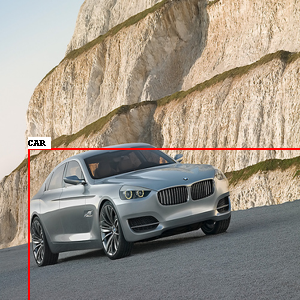

In [332]:
original_image = transforms.ToPILImage()(train_dataset[3][0])
# original_image
detect(original_image, min_score=0.2, max_overlap_threshold=0.5, keep_cutoff=200)